# Coursework 1 - Decision Trees Learning and K-Nearest Neighbors

### Candidate Number: 670028137

## Summary
In this coursework, your task is to develop a machine learning classifier for predicting female patients that at high risk of Diabetes. Your model is to support clinicians in identifying patients who are likely to have “Diabetes”. The dataset has 9 attributes in total including the “target/label” attribute. The full dataset is available on ELE under assessment coursework 1. The dataset consists of the following: 


## Dataset

1. preg: Number of times pregnant
2. plas: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. pres: Diastolic blood pressure (mm Hg)
4. skin: Triceps skin fold thickness (mm)
5. insu: 2-Hour serum insulin (mu U/ml)
6. mass: Body mass index (weight in kg/(height in m)^2)
7. pedi: Diabetes pedigree function
8. age: Age (years)
9. class: Class variable (0 or 1)

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from sklearn import preprocessing
import seaborn as sns
%matplotlib inline

dia_all = pd.read_csv("diabetes.txt") # This loads the full dataset 
                 # In the file, attributes are separated by ,

## Seperate the input (attributes) from target (label)

In [2]:
sourcevars = dia_all.iloc[:,:-1] #all rows + all columns except the last one
targetvar = dia_all.iloc[:,-1:] #all rows + only the last column

In [3]:
sourcevars.head()

,preg,plas,pres,skin,insu,mass,pedi,age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [4]:
targetvar.head()

,class
0,tested_positive
1,tested_negative
2,tested_positive
3,tested_negative
4,tested_positive


# Your answers
Please clearly highlight each task.

   # Task 1: Exploratory Data Analysis

The first step I have done to explore the data is to look at its description. Pandas can return tabular information about a dataframe with useful information such as minimum and maximum values for each attribute.

In [5]:
dia_all.describe()

,preg,plas,pres,skin,insu,mass,pedi,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


Some values in the data do not make sense to be zero. For example, a person cannot have 0 BMI. Attributes should be replaced with NaN when they are missing. This prevents models being trained on invalid data later on.

In [6]:
# Replace 0 with NaN where 0 does not make sense
dia_all['plas'].replace(0, np.nan, inplace=True)
dia_all['pres'].replace(0, np.nan, inplace=True)
dia_all['skin'].replace(0, np.nan, inplace=True)
dia_all['insu'].replace(0, np.nan, inplace=True)
dia_all['mass'].replace(0, np.nan, inplace=True)
dia_all['pedi'].replace(0, np.nan, inplace=True)

# Update source and target dataframes with new NaN values
sourcevars = dia_all.iloc[:,:-1] #all rows + all columns except the last one
targetvar = dia_all.iloc[:,-1:] #all rows + only the last column

## Chart #1
The first chart that I have drawn to understand the data is a boxplot for each attribute of the data. This is useful because it tells us a few things about the data. It gives us an intuition for the range of values for each attribute and their spread. 

From the chart below, insulin stands out as an attribute with a very wide range and a lot of outliers. It also has a positive skew of values suggesting that lower levels are more common.  

<AxesSubplot:>

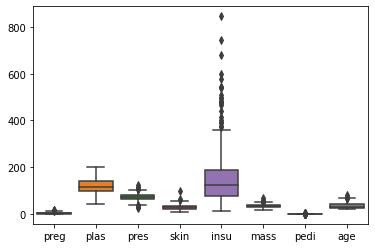

In [7]:
sns.boxplot(data=sourcevars)

## Chart #2
The second chart plotted BMI against triceps skin fold thickness. I have also coloured data points that tested positive in orange. This will allow me to see a predictable positive correlation relationship. It will also show me how these values differ for positive patients against negative patients.

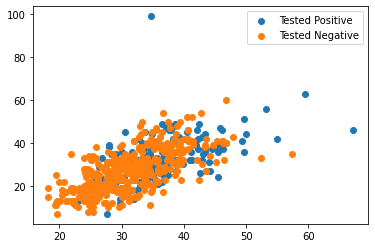

In [8]:
plt.scatter(dia_all['mass'][dia_all['class'] == 'tested_positive'], dia_all['skin'][dia_all['class'] == 'tested_positive'], label="Tested Positive")
plt.scatter(dia_all['mass'][dia_all['class'] == 'tested_negative'], dia_all['skin'][dia_all['class'] == 'tested_negative'], label="Tested Negative")
plt.legend()

# Correlation Analysis
I will be performing correlation analysis between 2-Hour serum inslulin and Plasma glucose concenrtation.

Pearson's rank of correlation for plasma against insulin:  0.5811862089121649


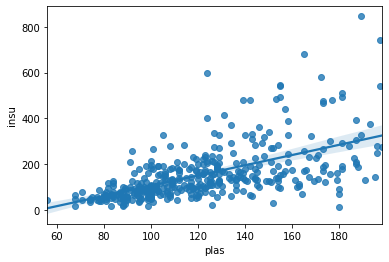

In [9]:
sns.regplot(x=sourcevars['plas'], y=sourcevars['insu'])

print("Pearson's rank of correlation for plasma against insulin: ", sourcevars['insu'].corr(sourcevars['plas']))

Above, we can see that the level of insluin is positively correlated to the level of glucose in the patient's blood. This makes logical sense as the body increases insluin levels to respond to an increase in glucose. 

# Task 2: Classification

## Data Preprocessing
Before the data is used for training models, it should be processed. Before, we replaced any zero values that do not make sense with NaN. These missing values will cause errors when feeding them to our models. 

We need to find suitable values to replace the zeros with.

The way I have chosen to do this is to replace them with the mean value for that attribute. This has the benefit of being a value that makes sense in context. The data will not be skewed by outliers. 

We then want to scale the data. Although this is not useful for the decision trees, it will be useful when creating the KNN models. KNN uses euclidian distance. We scale the attributes so that one individual feature does not 'weigh' more than others on the model.

I have chosen to standardize the data instead of normalizing it. This is because my boxplot analysis of the data showed that there are many outliers in the dataset. Normalizing the data would have it heavily biased by these outliers.

In [10]:
# Standardisation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer

# Replace zero values with mean value for attribute
imp_mean = SimpleImputer(missing_values=np.nan)
imp_mean.fit(sourcevars)
transformed = imp_mean.transform(sourcevars)
sourcevars = pd.DataFrame(transformed, columns=sourcevars.columns)

# Standardise the values 
arr = sourcevars.values
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(arr)
standardsourcevars = pd.DataFrame(x_scaled, columns=sourcevars.columns)


Fold 1:
Gini Tree Result: 64.93506493506493%
Entropy Tree Result: 67.53246753246754%
Entropy tree performed better.

Fold 2:
Gini Tree Result: 61.68831168831169%
Entropy Tree Result: 64.93506493506493%
Entropy tree performed better.

Fold 3:
Gini Tree Result: 74.02597402597402%
Entropy Tree Result: 72.72727272727273%
Gini tree performed better.

Fold 4:
Gini Tree Result: 75.16339869281046%
Entropy Tree Result: 70.58823529411765%
Gini tree performed better.

Fold 5:
Gini Tree Result: 73.8562091503268%
Entropy Tree Result: 67.97385620915033%
Gini tree performed better.

Average Totals:
Gini Tree: 69.93379169849759%
Entropy Tree: 68.75137933961464%
Gini tree performed better.


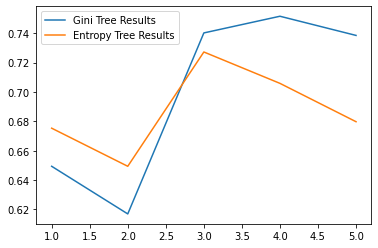

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.model_selection import KFold
from itertools import count

k5fold = KFold(n_splits=5, shuffle=False)

# Create trees using different evaluators
gini_tree = tree.DecisionTreeClassifier(criterion="gini", random_state=0)
entropy_tree = tree.DecisionTreeClassifier(criterion="entropy", random_state=0)

# Complete KFold cross validation on both trees
gini_tree_results = cross_val_score(gini_tree, standardsourcevars, targetvar, cv=k5fold)
entropy_tree_results = cross_val_score(entropy_tree, standardsourcevars, targetvar, cv=k5fold)

# Output results one fold at a time.
for i, gini_tree_result, entropy_tree_result in zip(count(), gini_tree_results, entropy_tree_results):
    print(f"Fold {i+1}:")
    print(f"Gini Tree Result: {gini_tree_result*100}%\nEntropy Tree Result: {entropy_tree_result*100}%")
    if gini_tree_result > entropy_tree_result:
        print("Gini tree performed better.")
    elif entropy_tree_result > gini_tree_result:
        print("Entropy tree performed better.")
    else:
        print("Both trees performed equally.")
    print()

# Find and print average performance
entropy_tree_average = np.mean(entropy_tree_results)*100
gini_tree_average = np.mean(gini_tree_results)*100
print("Average Totals:")
print(f"Gini Tree: {gini_tree_average}%\nEntropy Tree: {entropy_tree_average}%")
if gini_tree_average > entropy_tree_average:
    print("Gini tree performed better.")
elif entropy_tree_average > gini_tree_average:
    print("Entropy tree performed better.")
else:
    print("Both trees performed equally.")

# Plot results
plt.plot([1, 2, 3, 4, 5], gini_tree_results, label="Gini Tree Results")
plt.plot([1, 2, 3, 4, 5], entropy_tree_results, label="Entropy Tree Results")
plt.legend()

Fold 1:
One Neighbor Result: 69.48051948051948%
Three Neighbor Result: 74.67532467532467%
Five Neighbor Result: 74.67532467532467%

Fold 2:
One Neighbor Result: 64.28571428571429%
Three Neighbor Result: 71.42857142857143%
Five Neighbor Result: 71.42857142857143%

Fold 3:
One Neighbor Result: 71.42857142857143%
Three Neighbor Result: 72.72727272727273%
Five Neighbor Result: 72.72727272727273%

Fold 4:
One Neighbor Result: 75.16339869281046%
Three Neighbor Result: 75.81699346405229%
Five Neighbor Result: 76.47058823529412%

Fold 5:
One Neighbor Result: 65.359477124183%
Three Neighbor Result: 72.54901960784314%
Five Neighbor Result: 74.50980392156863%

Average totals: 
One Neighbour: 69.14353620235974%
Three Neighbour: 73.43943638061286%
Five Neighbour: 73.96231219760632%


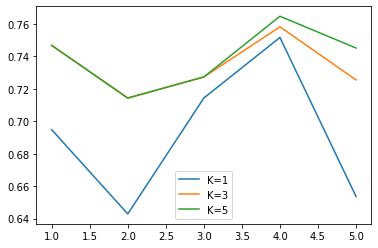

In [12]:
from sklearn.neighbors import KNeighborsClassifier

# Initialise KNN classifiers with n_neighbours parameters
k1 = KNeighborsClassifier(n_neighbors=1)
k3 = KNeighborsClassifier(n_neighbors=3)
k5 = KNeighborsClassifier(n_neighbors=5)

# Complete KFold validaiton on each classifier.
k1_results = cross_val_score(k1, standardsourcevars, np.ravel(targetvar), cv=k5fold)
k3_results = cross_val_score(k3, standardsourcevars, np.ravel(targetvar), cv=k5fold)
k5_results = cross_val_score(k5, standardsourcevars, np.ravel(targetvar), cv=k5fold)

# Output results
for i, k1_result, k3_result, k5_result in zip(count(), k1_results, k3_results, k5_results):
    print(f"Fold {i+1}:")
    print(f"One Neighbor Result: {k1_result*100}%")
    print(f"Three Neighbor Result: {k3_result*100}%")    
    print(f"Five Neighbor Result: {k5_result*100}%")  
    print()

# Find and output average results
print("Average totals: ")
print(f"One Neighbour: {np.mean(k1_results)*100}%")
print(f"Three Neighbour: {np.mean(k3_results)*100}%")
print(f"Five Neighbour: {np.mean(k5_results)*100}%")

# Graph results
plt.plot([1, 2, 3, 4, 5], k1_results, label="K=1")
plt.plot([1, 2, 3, 4, 5], k3_results, label="K=3")
plt.plot([1, 2, 3, 4, 5], k5_results, label="K=5")
plt.legend()

|   Min Samples Leaf |   Result Accuracy |
|--------------------+-------------------|
|                  2 |          0.714286 |
|                  3 |          0.718615 |
|                  4 |          0.709957 |
|                  5 |          0.735931 |


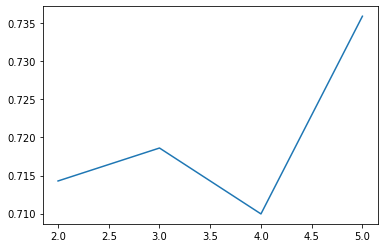

In [18]:
from sklearn.model_selection import train_test_split

# Split data 70:30 into training : testing data.
X_train, X_test, y_train, y_test = train_test_split(standardsourcevars, targetvar, train_size=0.7, shuffle=False)

tree_results = []

# Create decision trees for each minimum leaf value 2 - 5
for i in range(2, 6):
    dt = tree.DecisionTreeClassifier(min_samples_leaf=i, random_state=0)
    dt = dt.fit(X_train, y_train)
    tree_results.append(dt.score(X_test, y_test))

# Plot results
plt.plot(range(2, 6), tree_results)

print(tabulate(zip(range(2,6), tree_results), headers=["Min Samples Leaf", "Result Accuracy"], tablefmt='orgtbl'))

|   Max Depth |   Result Accuracy |
|-------------+-------------------|
|           3 |          0.748918 |
|           4 |          0.774892 |
|           5 |          0.779221 |
|           6 |          0.731602 |


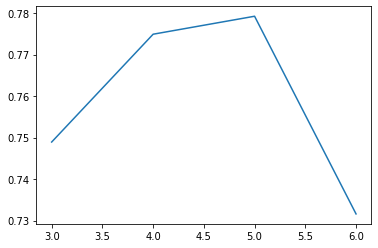

In [23]:
X_train, X_test, y_train, y_test = train_test_split(standardsourcevars, targetvar, train_size=0.7, shuffle=False)

tree_results = []

# Create decision trees for each minimum leaf value 3 - 6 
for i in range(3, 7):
    dt = tree.DecisionTreeClassifier(max_depth=i, random_state=0)
    dt = dt.fit(X_train, y_train)
    tree_results.append(dt.score(X_test, y_test))

# Plot results
plt.plot(range(3, 7), tree_results)

print(tabulate(zip(range(3,7), tree_results), headers=["Max Depth", "Result Accuracy"], tablefmt='orgtbl'))

# Reflection

## Interpretation / Explanation of the experiments and results


## Reflection on the results, advantages, and limitations of the methods used


## Justitication of the correlation attributes selection


## Possible improvements